In [21]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import shelve

BACKTEST = 1 # years, recommend at least 1~3 years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.4
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
SEED = 2400000 #a principal of 1,300,000KRW
lambda_penalty = 0.5 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [22]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'NVDA', 'AVGO', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
tickers = []

with shelve.open("ticker_cache") as cache:
    for ticker, name in cache.items():
        tickers.append(ticker)


In [23]:
#stock = yf.Ticker("379800.KS") #개별주 시장가 확인
stock = yf.Ticker("KRW=X") #환율
price = stock.info['regularMarketPrice']
print(stock.info['currency'] + " " + str(price))

KRW 1365.59


In [24]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

               007340.KS      271560.KS      307950.KS    005440.KS  \
Date                                                                  
2024-06-10  15659.908203   95544.367188  146089.187500  4188.381348   
2024-06-11  15659.908203   94861.210938  145004.125000  4140.404785   
2024-06-12  15484.829102   97789.023438  145300.046875  4197.977051   
2024-06-13  16457.494141   95153.992188  150626.734375  4058.843994   
2024-06-14  16165.694336   96520.304688  153092.781250  4217.167480   
2024-06-17  15757.174805  101887.968750  151415.875000  4193.179199   
2024-06-18  15640.455078   98472.179688  159504.531250  4293.930664   
2024-06-19  15543.188477   93006.929688  153881.921875  4274.739746   
2024-06-20  15504.282227   92909.335938  153290.078125  4289.132812   
2024-06-21  15407.015625   91738.210938  154572.421875  4327.514648   
2024-06-24  15407.015625   89591.140625  154671.062500  4265.144531   
2024-06-25  15407.015625   89395.953125  158419.468750  4279.537598   
2024-0

In [25]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [26]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           007340.KS  271560.KS  307950.KS  005440.KS  185750.KS  090430.KS  \
007340.KS   0.200186   0.025731   0.046599   0.027362   0.046354   0.045176   
271560.KS   0.025731   0.077169   0.005970  -0.007348   0.012699   0.021026   
307950.KS   0.046599   0.005970   0.110548   0.032033   0.041405   0.035513   
005440.KS   0.027362  -0.007348   0.032033   0.139647   0.021025   0.028174   
185750.KS   0.046354   0.012699   0.041405   0.021025   0.060326   0.042002   
090430.KS   0.045176   0.021026   0.035513   0.028174   0.042002   0.128823   
035900.KQ   0.006954   0.012388   0.041797   0.020695   0.024036   0.051575   
086280.KS   0.058179   0.009844   0.058948   0.051480   0.027985   0.026822   
009540.KS   0.033221  -0.012277   0.043958   0.057849   0.036993   0.043766   
383220.KS   0.039826   0.017585   0.037735   0.020288   0.045288   0.044485   
128940.KS   0.043166  -0.005910   0.051929   0.025865   0.049760   0.041951   
003090.KS   0.051216   0.020880   0.039180   0.03881

In [27]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [28]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [29]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [30]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '34e4735c415e19669e7094dbd83af34f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_47495/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [31]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
# constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
#               {'type': 'eq', 'fun': lambda weights: weights[tickers.index('379800.KS')] - 0.75}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [32]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [33]:
optimal_weights = optimized_results.x #.x gets the results

In [34]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [35]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [36]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 100
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [37]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
----------------------------------------------------------------------------------------------------
Returns                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                0.882329
Volatility                                                                                                                                                                                                                                                                                                                                                                                      

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [38]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [39]:
optimal_weights = optimized_results_max_sharpe.x
threshold = 10e-4

# print(optimal_weights)
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights (최적화 가중치):")
print("원금: " + f"{SEED:,}"+ "원. 백테스팅 기간: " + F"{BACKTEST}" + "년")
for ticker, weight in zip(tickers, optimal_weights):
    if weight >= threshold:
        num = round(SEED * weight)
        with shelve.open("ticker_cache") as cache:
            print(f"{ticker}({cache[ticker]}): {weight:.4f}" + ", 투자금액: " +  str(f"{num:,}") + "원")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights (최적화 가중치):
원금: 2,400,000원. 백테스팅 기간: 1년
271560.KS(ORION Corp.): 0.0421, 투자금액: 101,082원
005440.KS(Hyundai G.F. Holdings Co., Ltd.): 0.0804, 투자금액: 192,909원
272210.KS(Hanwha Systems Co., Ltd.): 0.0090, 투자금액: 21,631원
001800.KS(ORION Holdings Corp.): 0.0634, 투자금액: 152,058원
002795.KS(AMOREPACIFIC Holdings Corp.): 0.1976, 투자금액: 474,192원
012450.KS(Hanwha Aerospace Co., Ltd.): 0.0229, 투자금액: 55,057원
064350.KS(Hyundai Rotem Company): 0.0590, 투자금액: 141,530원
022100.KS(Posco Dx Company Ltd.): 0.0171, 투자금액: 41,153원
111770.KS(Youngone Corporation): 0.0467, 투자금액: 112,177원
089860.KS(LOTTE rental co.,ltd.): 0.0873, 투자금액: 209,556원
214450.KQ(PharmaResearch Co., Ltd.): 0.1104, 투자금액: 264,980원
000720.KS(Hyundai Engineering & Construction Co.,Ltd.): 0.1542, 투자금액: 370,047원
009970.KS(Youngone Holdings Co., Ltd.): 0.1098, 투자금액: 263,627원
Expected Annual Return: 1.6408
Expected Volatility: 0.2073
Sharpe Ratio: 7.7030


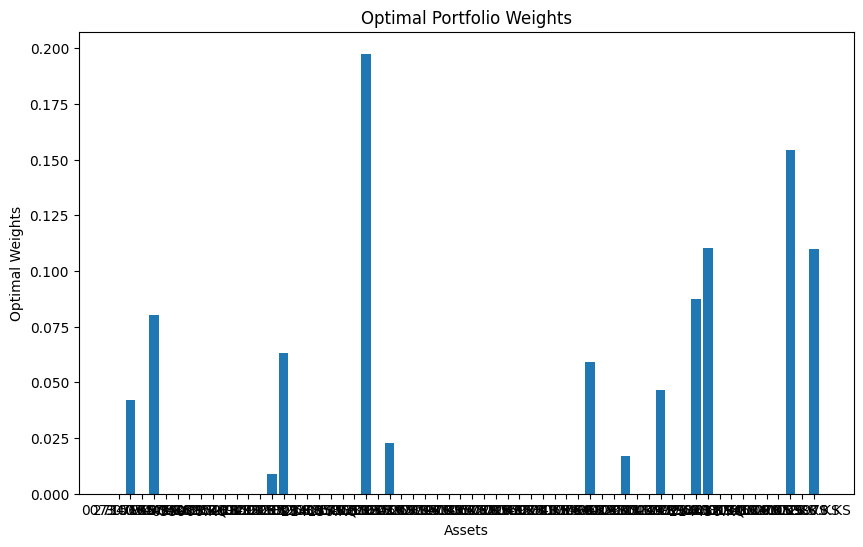

In [40]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()